# Логистические модели. Задачи классификации

### 1D классификация

Рассмотрим одномерный пример. У нас есть данные по массе мышей. Часть из них определена как мыши с нормальной массой тела, а часть — как мыши с ожирением. Чтобы их отделить друг от друга, нам достаточно одного критерия. Мы можем посмотреть на график и визуально определить предельную массу, после которой мышки будут жирненькими.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score 

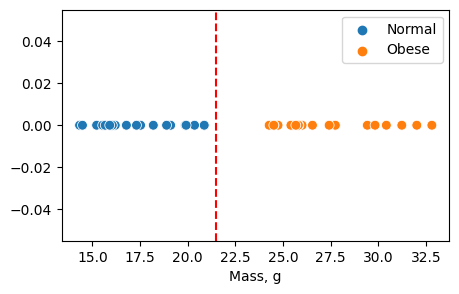

In [2]:
def generate_data(total_len=40):
    x = np.hstack(
        [
            np.random.uniform(14, 21, total_len // 2),
            np.random.uniform(24, 33, total_len // 2),
        ]
    )
    y = np.hstack([np.zeros(total_len // 2), np.ones(total_len // 2)])
    return x, y


def plot_data(x, y, total_len=40, s=50, threshold=None, margin=None):
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s)
    if threshold:
        ax.axvline(threshold, color="red", ls="dashed")
    if margin:
        for line in margin:
            ax.axvline(line, color="pink", ls="dashed")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Normal", "Obese"])
    ax.set(xlabel="Mass, g")
    return ax


total_len = 40
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data(x, y, threshold=21.5, total_len=total_len)

Теперь, пользуясь нашим простым критерием, попробуем классифицировать каких-то новых мышей.

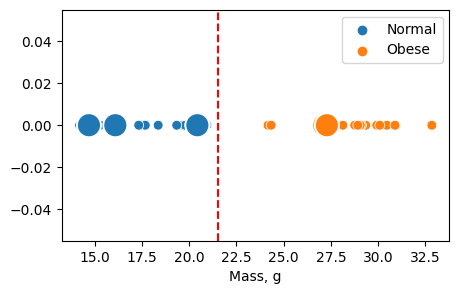

In [3]:
x_test = np.random.uniform(14, 30, 5)


def classify(x, threshold=21.5):
    y = np.zeros_like(x)
    y[x > threshold] = 1
    return y


total_len = 40
threshold = 21.5
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data(x, y, threshold=threshold, total_len=total_len)
ax = plot_data(x_test, classify(x_test, threshold), total_len=total_len, s=300)

Но что если наши мыши находятся тут?


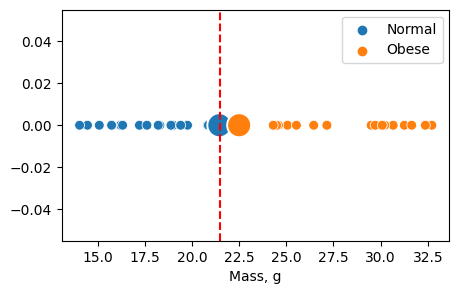

In [4]:
x_test = np.array([21.45, 22.5])

total_len = 40
x, y = generate_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data(x, y, total_len=total_len)
ax = plot_data(x_test, classify(x_test), threshold=21.5, total_len=total_len, s=300)

С точки зрения нашего классификатора, все просто: больше порогового значения — толстые мыши, меньше — нормальные. Но, с точки зрения здравого смысла, логичнее было бы классифицировать обоих мышей как нормальных, так как они значительно ближе к нормальным, чем к ожиревшим.

Вооружившись этим новым знанием, попробуем классифицировать наших отъевшихся мышек по-умному. Возьмем крайние точки в каждом кластере. И в качестве порогового значения будем использовать среднее между ними.

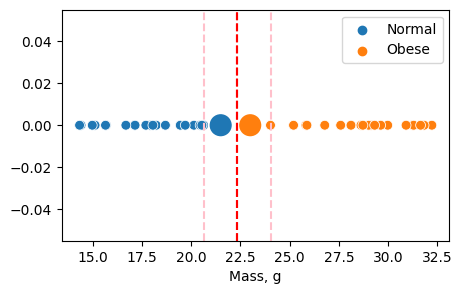

In [5]:
x, y = generate_data(total_len=total_len)
normal_limit = x[y == 0].max()  # extreme point for 'normal'
obese_limit = x[y == 1].min()  # extreme point for 'obese'

threshold = np.mean([normal_limit, obese_limit])  # separated with mean value

x_test = np.array([21.5, 23])
plt.figure(figsize=(5, 3))
ax = plot_data(
    x, y, total_len=total_len, threshold=threshold, margin=[normal_limit, obese_limit]
)
ax = plot_data(
    x_test,
    classify(x_test, threshold=threshold),
    total_len=total_len,
    s=300,
    threshold=threshold,
)

Мы можем посчитать, насколько наша мышь близка к тому, чтобы оказаться в другом классе. Такое расстояние называется **margin**. И оно считается как $\mathrm{margin} = |\mathrm{threshold} - \mathrm{observation}|$

In [6]:
margins = np.abs(x_test - threshold)
print(margins)

[0.83390304 0.66609696]


Соответственно, если мы посчитаем margins для наших крайних точек `normal_limit` и `obese_limit`, мы найдем самое большое возможное значение margin для нашего классификатора

In [7]:
margin_0 = np.abs(normal_limit - threshold)
margin_1 = np.abs(obese_limit - threshold)
print(margin_0, margin_1)

1.6959111435516014 1.6959111435516014


Такой классификатор мы называем **Maximum Margin Classifier**. Он хорошо работает в случае, когда все данные размечены аккуратно. Теперь рассмотрим более реалистичный пример, где что-то пошло не так.

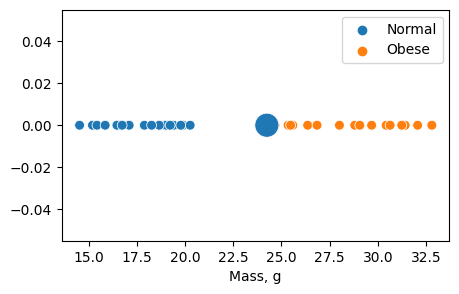

In [8]:
def generate_realistic_data(total_len=40):
    x = np.hstack(
        [
            np.random.uniform(14, 21, total_len // 2),
            np.random.uniform(24, 33, total_len // 2),
        ]
    )
    y = np.hstack([np.zeros(total_len // 2), np.ones(total_len // 2)])
    indx = np.where(x == x[y == 1].min())[0]
    y[indx] = 0
    s = np.ones_like(x) * 50
    s[indx] = 300
    return x, y, s


total_len = 40
x, y, s = generate_realistic_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data(x, y, total_len=total_len, s=s)

В таком случае наш **Maximum Margin Classifier** работать не будет. Исходя из этого, мы можем прийти к выводу, что наш классификатор очень чувствителен к выбросам. Решение этой проблемы будет рассмотрено в следующем разделе.

### 2D классификация

Теперь рассмотрим пример, где мы измерили не только вес мышей, но и их длину от хвоста до носа. Мы можем применить метод Support Vector Classifier, и теперь классы разделяет не одно пороговое значение (по сути, точка), а линия.

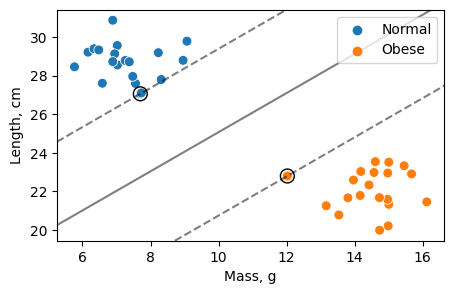

In [9]:
from sklearn import svm
from sklearn.datasets import make_blobs


def generate_2d_data(total_len=40):
    x, y = make_blobs(n_samples=total_len, centers=2, random_state=42)
    x[:, 0] += 10
    x[:, 1] += 20
    return x, y


def plot_data(x, y, total_len=40, s=50, threshold=21.5):
    ax = sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Normal", "Obese"])
    ax.set(xlabel="Mass, g", ylabel="Length, cm")
    return ax


total_len = 40
x, y = generate_2d_data(total_len=total_len)
plt.figure(figsize=(5, 3))
ax = plot_data(x, y, total_len=total_len)

# Code for illustration, later we will understand how it works
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(x, y)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

### 3D классификация

Если мы добавим еще одно измерение — возраст, мы обнаружим, что наши данные стали трехмерными, а разделяет их теперь не линия, а плоскость.

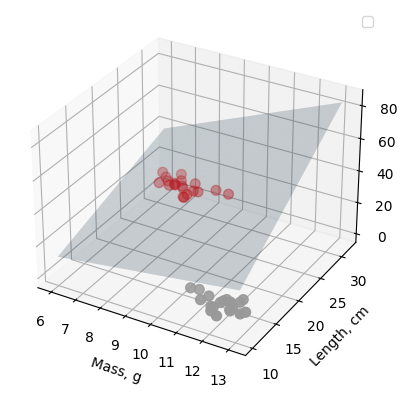

In [10]:
def generate_3d_data(total_len=40):
    x, y = make_blobs(n_samples=total_len, centers=2, random_state=42, n_features=3)
    x[:, 0] += 10
    x[:, 1] += 20
    x[:, 2] += 10
    return x, y


def plot_data(x, y, total_len=40, s=50, threshold=21.5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(xs=x[:, 0], ys=x[:, 1], zs=x[:, 2], c=y, s=s, cmap="Set1")
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    ax.plot_surface(XX, YY, XX * YY * 0.2, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Normal", "Obese"])
    ax.set(xlabel="Mass, g", ylabel="Length, cm", zlabel="Age, days")
    return ax


total_len = 40
x, y = generate_3d_data(total_len=total_len)
ax = plot_data(x, y, total_len=total_len)

Соответственно, если бы у нас было 4 измерения и больше (например: вес, длина, возраст, кровяное давление), то многомерная плоскость, которая бы разделяла наши классы, называлась бы **гиперплоскость** (рисовать мы ее, конечно же, не будем). Чисто технически, и точка, и линия — тоже гиперплоскости. Но все же гиперплоскостью принято называть то, что нельзя нарисовать на бумаге.

### Геометрическая интерпретация

Теперь, когда мы разобрались с тем, что такое регрессия, вернемся к задаче классификации изображений из датасета CIFAR-10. Как можно применить регрессию для классификации?

Предположим, у нас есть только 2 класса. Как можно использовать регрессию для того, чтобы определить относится ли изображение к классу 0 или к классу 1? В упрощенном варианте задача будет состоять в том, чтобы провести разделяющую плоскость (прямую) между 2-мя классами. Например, мы можем провести прямую через 0.

Такая прямая будет задана направляющим вектором $\vec W$, число компонентов которого будет равно размерности пространства признаков. Уравнение гиперплоскоскости в этом случае имеет вид

$$\large \sum_i W_i \cdot x_i = 0$$
или, что эквивалентно:
$$\large ( \vec W , \vec x) = 0$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/regression_for_classification_imgs.png" width="270">





Рассмотрим другую ситуацию. В этом случае мы не можем просто провести прямую через 0, но можем отступить от 0 на какое-то расстояние и провести ее там. Вспомним, что уравнение прямой это $y=wx+b$, где $b$ — это смещение (*bias*). Соответственно, если b != 0, то прямая через 0 проходить не будет, а будет проходить через значение b.

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/regression_for_classification_add_bias.png" width="270">

Таким образом, для классификации объектов на два класса нам нужно подобрать значение вектора $W$ и величину смещения $B$. Вместе они зададут гиперплоскость вида:
$$\large ( \vec W , \vec x) - B = 0$$

[Linear Classification Loss Visualization
](http://vision.stanford.edu/teaching/cs231n-demos/linear-classify/)


Если у нас есть несколько классов, мы можем для каждого из них посчитать уравнение $y_{i} = w_{i}x_{i}+b_{i}$.

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/regression_for_classification_add_bias_add_multiclasses.jpg" width="400">







На картинке нас интересуют 3 класса. Соответственно, мы можем записать систему линейных уравнений:

\begin{cases}
y_{0} = w_{0}x_{0} + b_{0} \\
y_{1} = w_{1}x_{1} + b_{1} \\
y_{2} = w_{2}x_{2} + b_{2} \\
\end{cases}

### Единообразный подход к учету смещения

Мы их можем собрать в матрицу, тогда получится следующее:

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/scalar_product_add_bias.png" width="750">

У нас есть матрица коэффициентов, которые мы каким-то образом подобрали, пока ещё непонятно как. Есть вектор $x$, соответствующий изображению.

Мы умножаем вектор на матрицу, получаем нашу гиперплоскость для четырехмерного пространства в данном случае. Чтобы оно не лежало в 0, мы должны добавить смещение. И мы можем сделать это после, но можно взять и этот вектор смещения (вектор **b**) просто приписать к матрице **W**.

Что будет выходом такой конструкции? Мы умножили матрицу весов на наш вектор, соответствующий изображению, получили некоторый отклик. По этому отклику мы так же, как и при реализации метода ближайшего соседа можем судить: если он больше остальных, то мы предполагаем, что это кошка.


In [11]:
img = np.array([56, 231, 24, 2])
w_cat = np.array([0.2, -0.5, 0.1, 2.0])
print("Image ", img)
print("Weights ", w_cat)
print("img * w_cat ", img * w_cat)
print("sum ", (img * w_cat).sum())
print("Add bias ", (img * w_cat).sum() + 1.1)

Image  [ 56 231  24   2]
Weights  [ 0.2 -0.5  0.1  2. ]
img * w_cat  [  11.2 -115.5    2.4    4. ]
sum  -97.89999999999999
Add bias  -96.8


<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/img_to_function_get_scores.png" width="600">

Обозначим входное изображение как $x$, а шаблон для первого из классов как $w_0$.

Элементы пронумеруем подряд 1,2,3 … $n$. То есть развернем матрицу пикселей изображения в вектор.

Тогда результат сравнения изображения с этим шаблоном будет вычисляться по формуле: $x[0]*w_0[0] + x[1]*w_0[1] + … x[n-1]*w_0[n-1]$

**Предварительная обработка**

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/img_to_vector_to_compute_scalar_product.png" width="700">

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/scalar_product_ways_to_use.png" width="800">

Эта простая модель лежит в основе практически всех сложных моделей, которые мы будем рассматривать дальше. Внутри будем также пользоваться скалярным произведением.

В дальнейшем мы будем проходить сверточные сети, они работают очень похоже:
мы тоже накладываем шаблон на некоторую матрицу и перемножаем элементы, затем складываем. Единственное отличие — обычно ядро свертки меньше, чем размер самого изображения.



Собирая все вместе, получаем какое-то компактное представление, что у нас есть некоторая функция, на вход которой мы подаем изображение, и у нее есть параметры (веса). Пока происходит просто умножение вектора на матрицу, в дальнейшем это может быть что-то более сложное, функция будет представлять какую-то более сложную модель. А на выходе (для классификатора) мы получаем числа, которые интерпретируют уверенность модели в том, что изображение принадлежит к определенному классу.


<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/input_img_scalar_product_add_bias_get_scores.png" width="450">

Соответственно, эти коэффициенты, которые являются весами модели, надо каким-то образом подбирать. Но прежде чем подбирать коэффициенты, давайте определимся со следующим: как мы будем понимать, что модель работает хорошо или плохо? Вывод модели представляет собой просто некоторый набор чисел. Но как эти числа следует правильно интерпретировать? Рассмотрим этот вопрос в следующем разделе.

## Линейный классификатор с пороговой функций принятия решения. Hard Margin Classifier

Рассмотрим пример задачи классификации на два класса. У нас имеется:
1. Набор данных из $N$ наблюдений.
2. Для каждого из наблюдений нам известно признаковое описание объекта в виде набора вещественных чисел. То есть объекту под номером $i$ соответствует вектор $\vec x_i$.
3. Также для каждого наблюдения нам известна истинная метка класса. Мы знаем что объекту с признаковым описанием $\vec x_i$ соответствует метка класса $y_i$. Будем считать, что метки классов принимают значения $y_i \in \pm 1$.

Мы хотим подобрать такие $\vec W$ и $B$, чтобы можно было провести такие гиперплоскости:

$$\large (\vec W \vec x) - B  = 1$$
**"Лежащие на этой плоскости и выше объекты относятся к классу $+1$"**

$$\large (\vec W \vec x) - B  = -1$$
**"Лежащие на этой плоскости и ниже объекты относятся к классу $-1$"**

Расстояние между двумя этими **жесткими** границами задаётся просто длиной вектора $\vec W$ и равно $\frac{2}{||\vec W||}$

Условие того, что объекты лежат $(\vec x_i, y_i)$ лежат по правильную сторону от разделяющих поверхностей можно записать в совместно:

$$\large y_i ((\vec W, \vec x_i) - B )\ge 1,$$ которое должно выполняться для всех объектов $1 \le i \le N$.

Среди всех решений $\vec W$ и $B$, которые удовлетворяют условию выше, мы хотим подобрать такое, при котором пороговые разделяющие поверхности будут находится дальше всего. Так как расстояние между ними равно $\frac{2}{||\vec W||}$, мы приходим к следующей задаче на условный экстремум:

$$\large ||\vec W|| \rightarrow \min, \; y_i ((\vec W, \vec x_i) - B )\ge 1$$

Подобная задача на условный экстремум может быть решена при помощи [метода множителей Лагранжа](https://en.wikipedia.org/wiki/Lagrange_multiplier):

Найти $\alpha_i$, $\vec W$ и $B$, которые реализуют минимум функции потерь:

$$\large L =  (\vec W, \vec W) + \sum_i \alpha_i (y_i ((\vec W, \vec x_i) - B )$$

## Линейный классификатор с Hinge loss. Soft Margin Classifier

Мы можем модифицировать функцию потерь на одном примере, разрешив классификатору ошибаться и упорядочивать некоторые объекты по "неправильную" сторону от разделяющих поверхностей.
Данная модификация называется [Hinge_loss](https://en.wikipedia.org/wiki/Hinge_loss):
$$\large L_i = \max(0, 1 - y_i ((\vec W, \vec x_i) - B ))$$

Давайте рассмотрим, как линейная модель классификации с Hinge loss работает на практике. Мы можем применить линейный классификатор в том числе и к изображениям — достаточно просто вытянуть изображение из тензора формата $(\text{C}, \text{H}, \text{W})$ в $(\text{C} \cdot \text{H} \cdot \text{W})$-мерный вектор. Применим линейный классификатор к нескольким изображениям из датасета CIFAR-10:

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/model_predicted_scores_for_10_classes.png" width="550">

По аналогии с тем, что мы уже делали, мы можем сравнивать отклик на ключевой класс  (про который нам известно, что он на изображении, так как у нас есть метка этого класса) с остальными. Соответственно, мы подали изображение кошки и получили на выход вектор. Чем больше значение, тем больше вероятность того, что, по мнению модели, на изображении этот класс. Для кошки в данном случае это значение 2.9. Хорошо это или плохо? Нельзя сказать, пока мы не проанализировали остальную часть вектора. Если бы мы могли посмотреть на все значения в векторе, мы бы увидели, что есть значения больше, то есть в данном случае модель считает, что это собака, а не кошка, потому что для собаки значение максимально.

На основании этого можно построить некоторую оценку. Давайте смотреть на разницу правильного класса с неправильными. Насколько уверенность в кошке будет больше остальных, настолько хорошо работает наша модель.

Но поскольку нам важна не работа модели на конкретном изображении, а важно оценить ее работу в целом, то эту операцию нужно проделать либо для всего датасета, либо для некоторой выборки, которую мы подаем на вход и подсчитываем средний показатель. Этот показатель (насколько хорошо работает модель), называется функцией потерь, или **loss function**. Называется она так потому, что она показывает не то, насколько хорошо работает модель, а то, насколько плохо.

Дальше будет понятно, почему так удобнее (разница только в знаке). Как это посчитать для всего датасета?

Мы каким-то образом считаем loss для конкретного изображения, потом усредняем по всем изображениям.

Дано: 3 учебных примера, 3 класса. При некотором W баллы f (a, W) = Wx равны:

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/model_predicted_scores_for_3_classes.png" width="450">

Функция потерь показывает, насколько хорош наш текущий классификатор.

Дан датасет примеров:

$\begin{Bmatrix} (x_i,y_i)  \end{Bmatrix}_{i=1}^N 	$

Где **$x_i$** — изображение, **$y_i$** — метка (число).

Потери по набору данных — это среднее значение потерь для примеров:

$ L = {1 \over N}\sum_iL_i(f(x_i,W),y_i)$


Построим функцию потерь для одного примера $L_i(f(x_i,W),y_i)$:

1. Вычислим вектор значений прогнозов классификатора $s = f(x_i, W)$.
1. Для всех примеров рассмотрим разницу между оценкой на истинной категории и всеми оценками классификатора для неправильных категорий: $s_{y_i} - s_j$ для $j \neq y_i$.
1. Если получившаяся разница положительная и превышает некоторое пороговое значение («зазор»), которое мы установим равным $1$, то будем считать, что категория $j$ не мешает модели верно классифицировать входной объект, припишем категории $j$ нулевой вклад в $L_i(f(x_i,W),y_i)$.
1. Если получившаяся разница не превосходит установленного нами единичного «зазора», то мы будем считать что ответ классификатора $s_j$ в категории $j$ мешает верной классификации входного объекта. В этом случае припишем для категории $j$ аддитивный вклад в $L_i(f(x_i,W),y_i)$ равный $s_j-s_{y_i}+1$.

Описанную процедуру гораздо проще записать в виде формулы:


$L_i = \sum_{j\neq y_i}\begin{cases}
  0,  & \mbox{если } s_{y_i}\geq s_j+1\mbox{} \\
  s_j-s_{y_i}+1, & \mbox{если наоборот, то} \mbox{}
\end{cases}$

$=\sum_{j\neq y_i}max(0,s_j-s_{y_i}+1)$




Логика такая: если у нас уверенность модели в правильном классе большая, то модель работает хорошо и loss для данного конкретного примера должен быть равен нулю. Если есть класс, в котором модель уверена больше, чем в правильном, то loss должен быть не равен нулю, а отображать какую-то разницу, поскольку модель сильно ошиблась. При этом есть ещё одно соображение: что будет, если на выходе у правильного и ошибочного класса будут примерно равные веса? То есть, например, у кошки было бы 3.2, а у машины не 5.2, а 3.1. В этом случае ошибки нет, но понятно, что при небольшом изменении в данных (просто шум) скорее всего она появится.

То есть модель плохо отличает эти классы. Поэтому мы и вводили некоторый зазор, который должен быть между правильным и неправильным ответом.

Посмотрим на изображение снизу. У нас есть два класса: фиолетовые треугольники и синие квадраты, разделенные зазором. Также можем увидеть желтые треугольники и квадраты — это ошибочно распознанные классы.


<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/svm_decision_boundary.png" width="300">

И тоже учитывать его в loss function: сравнивать его результат для правильного класса не с чистым выходом для другого, а добавить к нему некоторую дельту (в данном случае — 1(единица)). Смотрим: если разница больше 0, то модель работает хорошо и $L_i = 0$. Если нет, то мы возвращаем эту разницу, и loss будет складываться из этих индивидуальных разниц.

$L_i = \sum_{j\neq y_i}\begin{cases}
  0,  & \mbox{если } s_{y_i}\geq s_j+1\mbox{} \\
  s_j-s_{y_i}+1, & \mbox{если наоборот, то} \mbox{}
\end{cases}$

$=\sum_{j\neq y_i}max(0,s_j-s_{y_i}+1)$

Ниже пример того, как считается loss.

Считаем функцию потерь для 1-ого изображения:

$$\large L_i = \sum_{j \neq y_i} \max(0, s_j-s_{y_i} +1)$$

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/compute_loss_use_model_scores_for_1_example.png" width="300">

$L_i = \max(0, 5.1-3.2+1) + \max(0, -1.7-3.2+1) = \max(0, 2.9) + \max(0, -3.9) = 2.9+0 = 2.9$

Также считаем потери для второго и третьего изображений:

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/compute_loss_use_model_scores_for_2.png" width="300">

$L_i = \max(0, 1.3-4.9+1) + \max(0, 2.0-4.9+1) = \max(0, -2.6) + \max(0, -1.9) = 0+0 = 0$

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/compute_loss_use_model_scores_for_3.png" width="300">

$L_i = \max(0, 2.2-(-3.1)+1) + \max(0, 2.5-(-3.1)+1) = \max(0, 6.3) + \max(0, 6.6) = 6.3+6.6 = 12.9$

Значения потерь получились следующие:

<font color=2BA8E0 size=6><pre>Потери: 2.9   0   12.9</pre></font>

Считаем среднее значение loss для всего датасета:

$ L = {1 \over N}\sum_{i=1}^N L_i$

$L={2.9 + 0 + 12.9 \over 3} = 5.27$


SVM loss

$L_i=\sum_{j\neq y_i}\max(0,s_j-s_{y_i}+1)$

### MSE-loss
$$MSE = \frac 1 N \sum_i(y_i - \hat{y_i})^2 $$

$y_i$, $\hat{y_i}$ — константы, не являются функциями друг от друга
$$\hat{y} = wx_i + b $$

$$\frac {\delta MSE} {\delta w} = \frac 1 N \sum \frac {\delta (y_i - \hat{y_i}) ^2} {\delta \hat{y_i}} \frac {\delta \hat{y_i}} {\delta w}$$




## Кросс-энтропия как общая функция потерь для задач классификации

### Переход к вероятностям

**Softmax**

[Видео от StatQuest, которое объясняет Softmax](https://www.youtube.com/watch?v=KpKog-L9veg)

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/scores_to_probability.png" width="750">

Перейти к вероятностям мы сможем, проведя с весами некоторые не очень сложные математические преобразования.

На слайде выше показано, почему выходы модели часто называют [logit’ами](https://en.wikipedia.org/wiki/Logit). Если предположить, что у нас есть некая вероятность, от которой мы берем такую функцию (logit), то результат может принимать значение в любых вещественных числах. Мы можем считать, что выходы модели — это logit’ы.

Например, мы могли бы просто взять индекс массива, в котором значение (logit) максимально. Предположим, что наша модель выдала следующие значения:

In [12]:
logits = [
    5.1,  # cat
    3.2,  # car
    -1.7,  # frog
]

Тогда, чтобы узнать какой класс наша сеть предсказала, мы могли бы просто взять `argmax` от наших `logits`

In [13]:
import numpy as np

print("Predicted class = %i (Cat)" % (np.argmax(logits)))

Predicted class = 0 (Cat)


Но от argmax нельзя посчитать градиент, так как производная от константы равна 0. Соответственно, если бы мы вставили производную от argmax в градиентный спуск, мы бы получили везде нули, и соответственно, наша модель бы вообще ничему не научилась

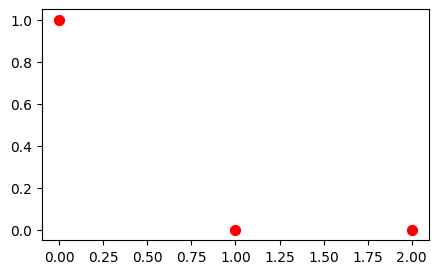

In [14]:
plt.figure(figsize=(5, 3))
plt.scatter(np.arange(3), [1, 0, 0], color="red", s=50)
plt.show()

А мы бы хотели получить не logit’ы, а настоящую вероятность на выходе модели. Да еще и таким образом, чтобы от наших вероятностей можно было посчитать градиент. Для этого мы можем применить к нашим логитам функцию **Softmax**

<img src ="https://edunet.kea.su/repo/EduNet-content/L02/out/linear_classifier_softmax.png" width="600">



Функция SoftMax:

$s=f(x_i; W);$

$ \displaystyle P(Y=k|X=x_i) = \frac{e^{s_k}}{\sum_je^{s_j}}.$

1. Отобразим наши logit’ы на значения $[0, +∞)$.

Для этого возведем экспоненту (число Эйлера 2.71828) в **степень логита**. В результате, мы получим вектор гарантированно неотрицательных чисел (положительное число, возведенное в степень, даже отрицательную, даст положительное значение).

2. Нормализуем.

Чтобы  интерпретировать числа как вероятности, их сумма должна быть равна единице. Мы должны их нормализовать, то есть **поделить на сумму**.

Это преобразование называется **Softmax функцией**. **Получаются вероятности**, то есть числа, которые можно интерпретировать, как вероятности.

$\large \displaystyle \text{Softmax}_\text{кошка} = \frac{e^{5.1}}{e^{5.1} + e^{3.2} + e^{-1.7}}$

In [15]:
def softmax(logits):
    return np.exp(logits) / np.sum(np.exp(logits))


print(softmax(logits))
print("Sum = %.2f" % np.sum(softmax(logits)))

[0.86904954 0.12998254 0.00096793]
Sum = 1.00


Можно обратить внимание, что Softmax никоим образом не поменял порядок значений. Самому большому logit'у соответствует самая большая вероятность, а самому маленькому, соответственно, самая маленькая.

Посмотрим на графиках. Возьмем массив случайных логитов и применим к ним softmax

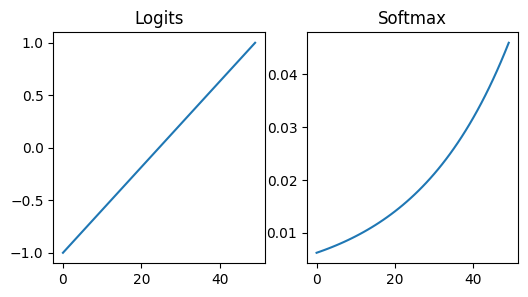

In [16]:
rand_logits = np.linspace(-1, 1, 50)
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))

ax[0].plot(np.arange(50), rand_logits)
ax[0].set_title("Logits")
ax[1].plot(np.arange(50), softmax(rand_logits))
ax[1].set_title("Softmax")
plt.show()

#### Практическое вычисление SoftMax

При вычислении экспоненты от выходов модели могут получиться очень большие числа в силу очень высокой скорости роста экспоненты. Этот факт необходимо учитывать, чтобы вычисления SoftMax были численно стабильны:

In [17]:
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

f = np.array([123, 456, 789])
p = np.exp(f) / np.sum(np.exp(f))
print(f, p)

[123 456 789] [ 0.  0. nan]


Чтобы регуляризовать вычисление, нам следует предварительно упростить возникающую в вычислении дробь. Для этого мы можем вычесть из каждого $s_i$ положительную константу, чтобы уменьшить значения экспонент. В качестве константы можно выбрать максимальный элемент этого вектора, тогда у нас гарантированно не будет очень больших чисел, и такой способ будет работать более стабильно.

$$M = \max_j s_{y_{j}}$$
$$s^{new}_{y_{i}}  = s_{y_{i}} - M $$

$$ \dfrac {e^{s^{new}_{y_{i}}}} {\sum_j e^{s^{new}_{y_{j}}}}  = \dfrac {e^{s_{y_{i}} - M }} {\sum_j e^{s_{y_{j}} - M }} = \dfrac {e^{s_{y_{i}}}e ^ {-M}} {\sum_j e^{s_{y_{j}}} e ^ {-M}} = \dfrac {e ^ {-M} e^{s_{y_{i}}}} {e ^ {-M} \sum_j e^{s_{y_{j}}} } = \dfrac { e^{s_{y_{i}}}} { \sum_j e^{s_{y_{j}}} }$$

In [18]:
f = np.array([123, 456, 789])
f -= f.max()
p = np.exp(f) / np.sum(np.exp(f))
print(f, p)

[-666 -333    0] [5.75274406e-290 2.39848787e-145 1.00000000e+000]


### Градиент функции потерь. Кросс-энтропия




[Cross Entropy Loss](https://wandb.ai/wandb_fc/russian/reports/---VmlldzoxNDI4NjAw#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%BF%D0%BE%D1%82%D0%B5%D1%80%D1%8C%20%D0%BF%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D0%B5%D1%81%D1%82%D0%BD%D0%BE%D0%B9%20%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D0%B8%20%E2%80%93%20%D1%8D%D1%82%D0%BE,%2C%20%D0%B3%D0%B4%D0%B5%200%20%E2%80%93%20%D0%B8%D0%B4%D0%B5%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F%20%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C.)

$$ -L = \sum_i y_i \log p_i = \sum_i y_i \log(\dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}})$$

$$s_{y_i} = w_i x$$

$$ \dfrac {\partial L} {\partial w_i} = \dfrac {\partial L} {\partial s_{y_i}} \dfrac {\partial s_{y_i}} {\partial w_i} $$

$$\dfrac {\partial s_{y_i}} {\partial w_i} = x$$

Только один $y_k = 1$


$$ -L = y_k \log p_i = \log(\dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}})$$

i = k

$$ -L = \log(\dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}}) = \log e^{s_{y_i}} - \log  \sum_j e^{s_{y_j}}  = s_{y_i} - \log  \sum_j e^{s_{y_j}}$$

$$\dfrac {\partial -L} {\partial s_{y_i}} = 1 - \dfrac 1 {\sum_j e^{s_{y_j}}} \cdot \dfrac {\partial {\sum_j e^{s_{y_j}}}} {\partial s_{y_i}} = 1 - \dfrac 1 {\sum_j e^{s_{y_i}}} \cdot \dfrac {\partial e^{s_{y_i}}} {\partial s_{y_i}} = 1 - \dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}} = 1 - p_i$$

$$\dfrac {\partial L} {\partial s_{y_j}} = p_i - 1 $$

$$ \dfrac {\partial L_i} {\partial w_i}  = \dfrac {\partial L} {\partial s_{y_i}} \dfrac {\partial s_{y_i}} {\partial w_i} = (p_i - 1) x $$

i != k

$$ -L = \log(\dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}}) = \log e^{s_{y_k}} - \log  \sum_j e^{s_{y_j}}  = s_{y_k} - \log  \sum_j e^{s_{y_j}}$$

$$\dfrac {\partial -L} {\partial s_{y_i}} = - \dfrac 1 {\sum_j e^{s_{y_j}}} \cdot \dfrac {\partial {\sum_j e^{s_{y_j}}}} {\partial s_{y_i}} =  \dfrac 1 {\sum_j e^{s_{y_i}}} \cdot \dfrac {\partial e^{s_{y_i}}} {\partial s_{y_i}} = \dfrac {e^{s_{y_i}}} {\sum_j e^{s_{y_j}}} = - p_i$$

$$\dfrac {\partial L} {\partial s_{y_j}} = p_i $$
$$ \dfrac {\partial L_i} {\partial w_i}  = \dfrac {\partial L} {\partial s_{y_i}} \dfrac {\partial s_{y_i}} {\partial w_i} = p_i x $$



В коде это будет выглядеть вот так:

In [19]:
# Input batch of 2 vector with 4 elements
x = np.array([[1, 2, 3, 4], [1, -2, 0, 0]])
# Weights
W = np.random.randn(3, 4)  # 3 class

# model output
logits = x.dot(W.T)
print("Scores(Logits) \n", logits, "\n")

# Probabilities
probs = softmax(logits)  # defined before
print("Probs \n", probs, "\n")

# Ground true classes
y = [0, 1]

# Derivative
probs[np.arange(2), y] = -1  # substract one from true class prob
dW = x.T.dot(probs)  # dot product with input

print("Grads dL/dW \n", dW)  # have same shape as W

Scores(Logits) 
 [[ 0.82221007  1.09850841  2.59859993]
 [ 0.89313172 -0.9837947   0.90686123]] 

Probs 
 [[0.09476093 0.12491775 0.55989377]
 [0.10172559 0.0155701  0.10313186]] 

Grads dL/dW 
 [[-0.89827441 -0.87508225  0.66302563]
 [-2.20345117  2.24983551  0.91352382]
 [-3.          0.37475326  1.6796813 ]
 [-4.          0.49967102  2.23957507]]
